# REGALS analysis of PheH titration data

The data were published in:

*Domain movements upon activation of phenylalanine hydroxylase characterized by crystallography and chromatography-coupled small-angle X-ray scattering*

Meisburger SP, Taylor AB, Khan CA, Zhang S, Fitzpatrick PF, Ando N.

JACS 138(20): 6506?16 (2016). http://dx.doi.org/10.1021/jacs.6b01563

In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *

import matplotlib.pyplot as plt

## Load data

In [2]:
PheH_titration = {}
with h5py.File('data/PheH_titration.mat', 'r') as f:
    for key in f:
        PheH_titration[key] = np.array(f[key])

#Store raw data
q = PheH_titration['q'][0]
I = PheH_titration['I'].T
sigma = PheH_titration['sigma'].T
phe = PheH_titration['phe'].T[0]

## Set up REGALS calculation

Each component has a concentration and profile regularizer.

In [3]:
x = phe.copy()
x[0] = 10 # use 10 micromolar for [phe] = 0 point
x = np.log10(x) # we're going to seek smoothness on a logarithmic scale


C1 = component(
    concentration_class('smooth', x, xmin = 1 - 1E-3, xmax = 3.5 + 1E-3, is_zero_at_xmin = False, is_zero_at_xmax = True, Nw = 21),
    profile_class('realspace',q, dmax = 130, Nw = 101))

C2 = component(
    concentration_class('smooth', x, xmin = 1 - 1E-3, xmax = 5 + 1E-3, is_zero_at_xmin = True, is_zero_at_xmax = False, Nw = 31),
    profile_class('realspace',q, dmax = 130, Nw = 101))

C3 = component(
    concentration_class('smooth', x, xmin = 1 - 1E-3, xmax = 5 + 1E-3, is_zero_at_xmin = False, is_zero_at_xmax = False, Nw = 31),
    profile_class('realspace',q, dmax = 300, Nw = 101))

M = mixture([C1,C2,C3])
M.lambda_concentration = np.array([1E1,1E1,1E1]) # M.estimate_concentration_lambda(sigma,[5,5,5])
M.lambda_profile = np.array([1E12,1E12,1E12])

## Run REGALS

In [4]:
R = regals(I,sigma) # creat REGALS object

# set stopFun to return true when 50 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 50, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3)))

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M,stop_fun,update_fun)

 1, x2 = 29.057538, delta_profile = [ 981.206 1203.761  536.631]
 2, x2 = 35.925201, delta_profile = [ 980.169 1204.276  531.469]
 3, x2 = 7.612028, delta_profile = [1.691 0.729 1.956]
 4, x2 = 7.349475, delta_profile = [1.062 0.177 0.745]
 5, x2 = 7.300829, delta_profile = [0.037 0.028 0.241]
 6, x2 = 7.258425, delta_profile = [0.02  0.033 0.068]
 7, x2 = 7.212980, delta_profile = [0.022 0.038 0.088]
 8, x2 = 7.137376, delta_profile = [0.028 0.045 0.112]
 9, x2 = 6.999705, delta_profile = [0.034 0.055 0.145]
10, x2 = 6.742969, delta_profile = [0.043 0.068 0.187]
11, x2 = 6.275013, delta_profile = [0.054 0.085 0.24 ]
12, x2 = 5.506465, delta_profile = [0.068 0.109 0.303]
13, x2 = 4.506710, delta_profile = [0.085 0.138 0.36 ]
14, x2 = 3.572843, delta_profile = [0.101 0.172 0.377]
15, x2 = 2.913388, delta_profile = [0.113 0.197 0.311]
16, x2 = 2.497186, delta_profile = [0.116 0.196 0.208]
17, x2 = 2.228608, delta_profile = [0.105 0.175 0.13 ]
18, x2 = 2.042685, delta_profile = [0.089 0.1

## Extract results to plot

In [5]:
# P(r) functions
r1 = M1.components[0].profile.w
pr1 = np.concatenate([[0],M1.u_profile[0],[0]])

r2 = M1.components[1].profile.w
pr2 = np.concatenate([[0],M1.u_profile[1],[0]])

r3 = M1.components[2].profile.w
pr3 = np.concatenate([[0],M1.u_profile[2],[0]])

# Particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0)
[I2,sigma2] = M1.extract_profile(I,sigma,1)
[I3,sigma3] = M1.extract_profile(I,sigma,2)

# Concentration components (no regularization)
p1 = M1.extract_concentration(I,sigma,0)[0]
p2 = M1.extract_concentration(I,sigma,1)[0]
p3 = M1.extract_concentration(I,sigma,2)[0]

# Regularized concentrations
x1 = np.concatenate([M1.components[0].concentration.w,[5 + 1E-3]])
c1 = np.concatenate([M1.u_concentration[0],[0,0]])
x2 = M1.components[1].concentration.w
c2 = np.concatenate([[0],M1.u_concentration[1]])
x3 = M1.components[2].concentration.w;
c3 = M1.u_concentration[2];

## Plot the end results

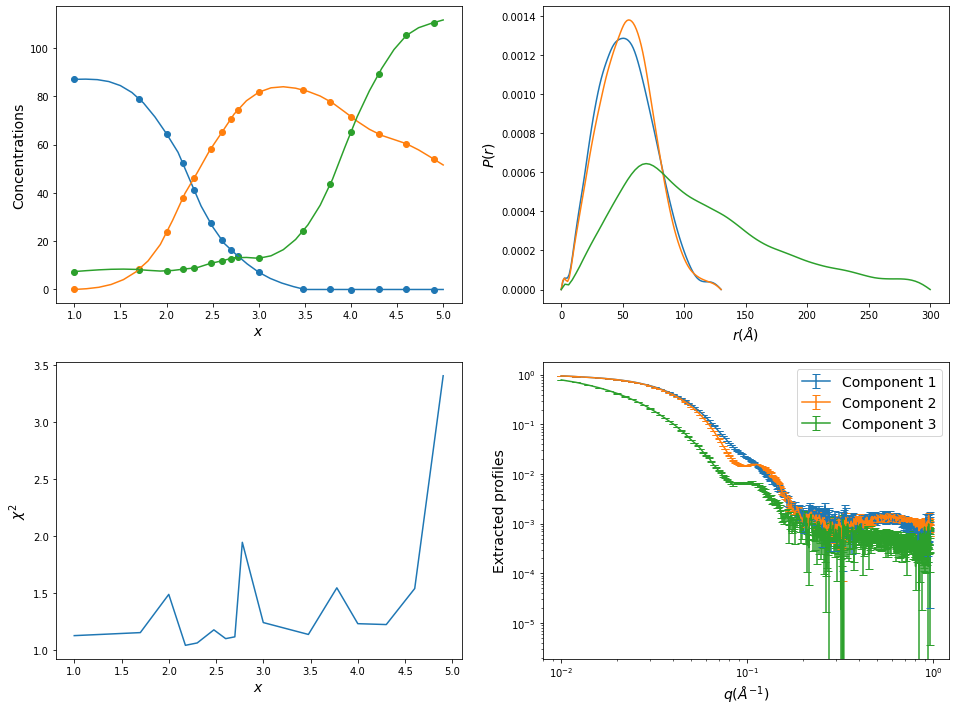

In [6]:
# plot the end results
plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#concentrations vs x
axs[0, 0].plot(x1, c1)
axs[0, 0].plot(x2, c2)
axs[0, 0].plot(x3, c3)
axs[0, 0].scatter(x, p1)
axs[0, 0].scatter(x, p2)
axs[0, 0].scatter(x, p3)
axs[0, 0].set_xlabel('$x$', fontsize=14)
axs[0, 0].set_ylabel('Concentrations', fontsize=14)

#chi2 vs x
axs[1, 0].plot(x, np.mean(resid ** 2, 0))
axs[1, 0].set_xlabel('$x$', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#P(r) vs r
axs[0, 1].plot(r1, pr1)
axs[0, 1].plot(r2, pr2)
axs[0, 1].plot(r3, pr3)
axs[0, 1].set_xlabel('$r (Å)$', fontsize=14)
axs[0, 1].set_ylabel('$P(r)$', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].errorbar(q, I3, sigma3, capsize=4, label='Component 3')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()